In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
from tqdm import tqdm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

In [3]:
class RBM(nn.Module):
    def __init__(self,
                 n_vis=784,
                 n_hin=500,
                 k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self,v):   ## function 3.4 , 3.6
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias)) ## 3.4
        sample_h = self.sample_from_p(p_h)  ## 3.6
        return p_h,sample_h
    
    def h_to_v(self,h): ## function 3.3 , 3.5
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias)) ## 3.3
        sample_v = self.sample_from_p(p_v) ## 3.5
        return p_v,sample_v
        
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
rbm = RBM(k=1)

In [6]:
train_op = optim.SGD(rbm.parameters(),0.1)

In [7]:
for epoch in tqdm(range(10)):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.item())
        train_op.zero_grad()
        loss.backward()
        train_op.step()
    
    print(np.mean(loss_))

  0% 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 10% 1/10 [00:20<03:04, 20.50s/it]

-8.410612094122717



 20% 2/10 [00:38<02:33, 19.20s/it]

-6.6656648680599515



 30% 3/10 [00:57<02:12, 18.88s/it]

-4.558168455990138



 40% 4/10 [01:16<01:53, 18.85s/it]

-3.228492818153235



 50% 5/10 [01:35<01:34, 18.89s/it]

-2.2697118502944265



 60% 6/10 [01:53<01:15, 18.90s/it]

-1.6326928372576293



 70% 7/10 [02:12<00:56, 18.79s/it]

-1.13509019148121



 80% 8/10 [02:31<00:37, 18.77s/it]

-0.7930302731772222



 90% 9/10 [02:49<00:18, 18.61s/it]

-0.5629324191160547


100% 10/10 [03:07<00:00, 18.77s/it]

-0.32969685048182634


In [8]:
sample_data.shape

torch.Size([32, 784])

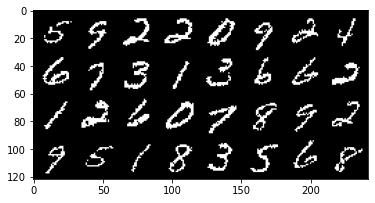

In [9]:
show_adn_save("real",make_grid(v.view(32,1,28,28).data))

In [11]:
v.shape

torch.Size([32, 784])

In [12]:
v1.shape

torch.Size([32, 784])

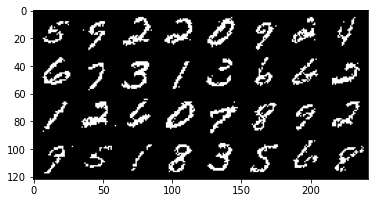

In [10]:
show_adn_save("generate",make_grid(v1.view(32,1,28,28).data))